In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Load data
df = pd.read_csv('C:/Users/Sayan Mondal/Downloads/demand_inventory.csv')
df['Date'] = pd.to_datetime(df['Date'])

In [3]:
print(df.head())

   Unnamed: 0       Date Product_ID  Demand  Inventory
0           0 2023-06-01         P1      51       5500
1           1 2023-06-02         P1     141       5449
2           2 2023-06-03         P1     172       5308
3           3 2023-06-04         P1      91       5136
4           4 2023-06-05         P1     198       5045


In [4]:
df.describe()

,Unnamed: 0,Demand,Inventory
count,62.000000,62.000000,62.000000
mean,30.500000,120.709677,2073.822581
std,18.041619,44.852906,1840.782144
min,0.000000,51.000000,0.000000
25%,15.250000,85.000000,25.500000
50%,30.500000,124.000000,1908.000000
75%,45.750000,152.750000,3594.250000
max,61.000000,199.000000,5500.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  62 non-null     int64         
 1   Date        62 non-null     datetime64[ns]
 2   Product_ID  62 non-null     object        
 3   Demand      62 non-null     int64         
 4   Inventory   62 non-null     int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 2.5+ KB


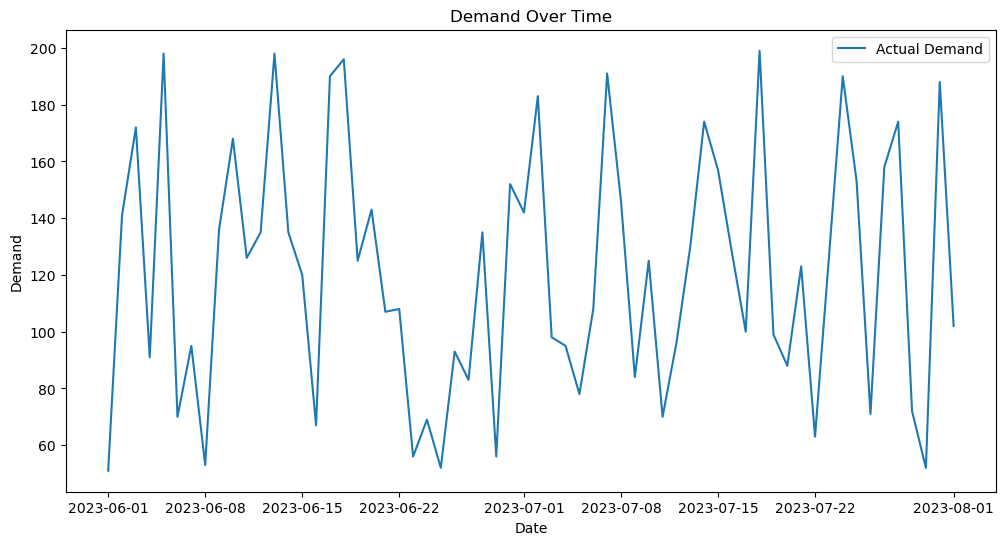

In [6]:
# Visualize demand over time
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Demand'], label='Actual Demand')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Demand Over Time')
plt.legend()
plt.show()

C:\Users\Sayan Mondal\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


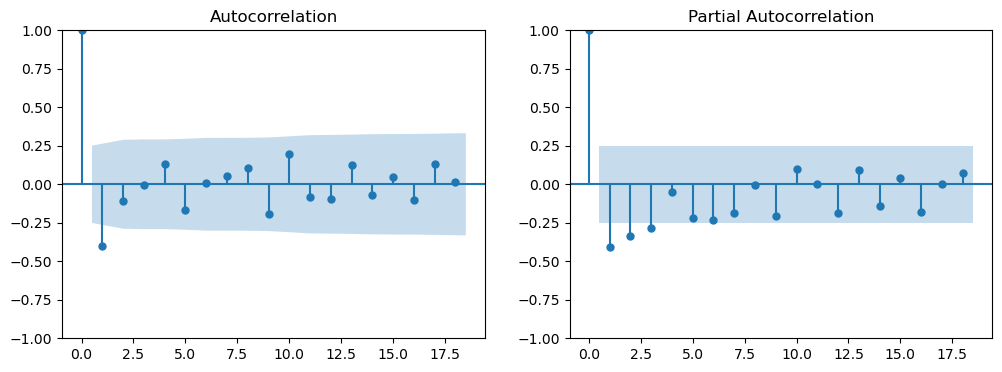

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
df['Date'] = pd.to_datetime(df['Date'],
                                     format='%Y/%m/%d')
time_series = df.set_index('Date')['Demand']

differenced_series = time_series.diff().dropna()

# Plot ACF and PACF of differenced time series
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(differenced_series, ax=axes[0])
plot_pacf(differenced_series, ax=axes[1])
plt.show()

In [10]:
import pandas as pd
from sklearn.metrics import mean_absolute_error

# Assuming df is your DataFrame

# Calculate Naive Forecast
df['Naive_Forecast'] = df['Demand'].shift(1)

# Drop NaN values from both series
y_true_naive = df['Demand'].dropna()  # Exclude the first row
y_pred_naive = df['Naive_Forecast'].dropna()  # Exclude the last row

# Ensure both series start from the same point
start_index = max(y_true_naive.index.min(), y_pred_naive.index.min())
y_true_naive = y_true_naive.loc[start_index:]
y_pred_naive = y_pred_naive.loc[start_index:]
print(y_true_naive.shape, y_pred_naive.shape)
# Calculate MAE for Naive Forecast
mae_naive = mean_absolute_error(y_true_naive, y_pred_naive)

# Print MAE for Naive Forecast
print(f"MAE for Naive Forecast: {mae_naive:.2f}")


(61,) (61,)
MAE for Naive Forecast: 51.26


MAE for Moving Average Forecast: 35.50


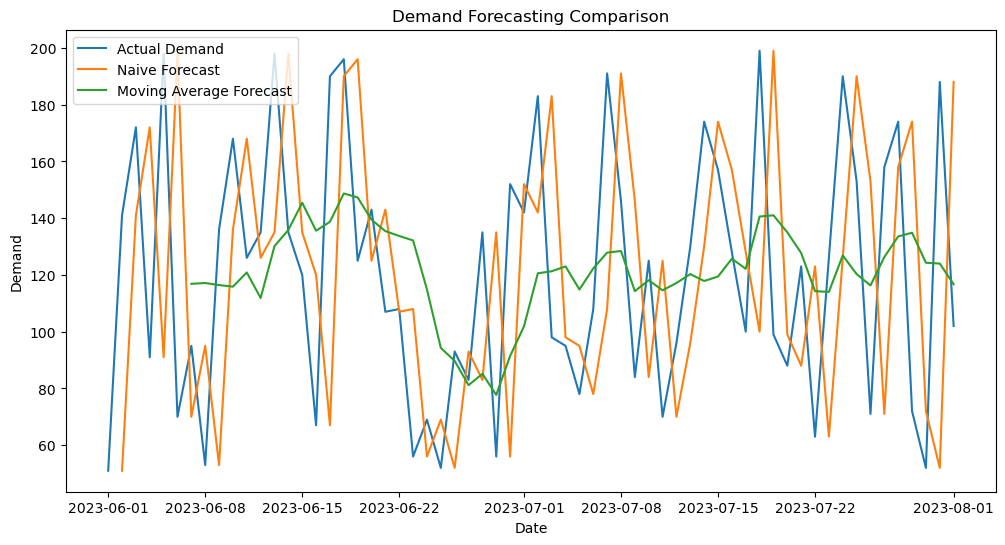

In [11]:
# Calculate Moving Average Forecast
window_size = 7  # Adjust as needed
df['Moving_Average_Forecast'] = df['Demand'].rolling(window=window_size).mean()

# Calculate MAE for Moving Average Forecast
mae_moving_average = mean_absolute_error(df['Demand'].dropna()[window_size-1:], df['Moving_Average_Forecast'].dropna())


# Print MAE for Moving Average Forecast
print(f"MAE for Moving Average Forecast: {mae_moving_average:.2f}")

# Visualize actual demand, naive forecast, seasonal naive forecast, and moving average forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Demand'], label='Actual Demand')
plt.plot(df['Date'], df['Naive_Forecast'], label='Naive Forecast')
#plt.plot(df['Date'], df['Seasonal_Naive_Forecast'], label='Seasonal Naive Forecast')
plt.plot(df['Date'], df['Moving_Average_Forecast'], label='Moving Average Forecast')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Demand Forecasting Comparison')
plt.legend()
plt.show()

In [12]:
# Calculate improvement percentages
percentage_improvement_naive = ((mae_naive - mae_moving_average) / mae_naive) * 100


# Print improvement percentages
print(f"Percentage Improvement over Naive Forecast: {percentage_improvement_naive:.2f}%")

Percentage Improvement over Naive Forecast: 30.75%


In [13]:
import pmdarima as pm

# Assuming df is your DataFrame
# Specify the column containing the demand data
demand_data = df['Demand']

# Use auto_arima to determine the optimal PDQ values
model = pm.auto_arima(demand_data, seasonal=False, suppress_warnings=True)

# Extract the optimal PDQ values
p, d, q = model.order

# Print the optimal PDQ values
print(f"Optimal PDQ values: p={p}, d={d}, q={q}")


Optimal PDQ values: p=0, d=0, q=0


In [15]:
from statsmodels.tsa.arima.model import ARIMA
# Fit the ARIMA model
model = ARIMA(df['Demand'], order=(p, d, q))
model_fit = model.fit()

In [19]:
# Generate the forecast
n=7
forecast_values = model_fit.predict(start=len(df), end=len(df)+n, typ='levels')
print(forecast_values)

62    120.709673
63    120.709673
64    120.709673
65    120.709673
66    120.709673
67    120.709673
68    120.709673
69    120.709673
Name: predicted_mean, dtype: float64


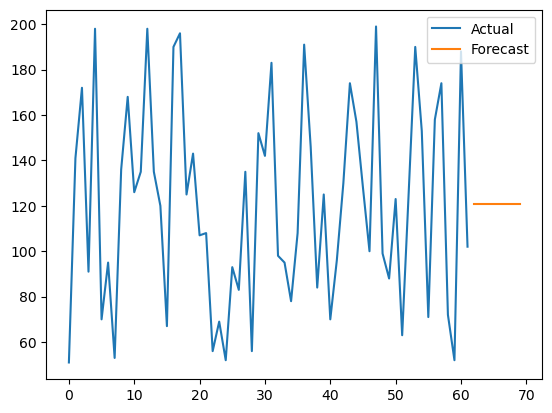

In [20]:
# Visualize the forecast
plt.plot(df['Demand'], label='Actual')
plt.plot(forecast_values, label='Forecast')
plt.legend()
plt.show()


In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 2) #2 because the data contains a time period of 2 months only
model = SARIMAX(time_series, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

future_steps = 10
predictions = model_fit.predict(len(time_series), len(time_series) + future_steps - 1)
predictions = predictions.astype(int)
print(predictions)

2023-08-02    117
2023-08-03    116
2023-08-04    130
2023-08-05    114
2023-08-06    128
2023-08-07    115
2023-08-08    129
2023-08-09    115
2023-08-10    129
2023-08-11    115
Freq: D, Name: predicted_mean, dtype: int32


C:\Users\Sayan Mondal\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Sayan Mondal\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [24]:
import numpy as np
# Create date indices for the future predictions
future_dates = pd.date_range(start=time_series.index[-1] + pd.DateOffset(days=1), periods=future_steps, freq='D')

# Create a pandas Series with the predicted values and date indices
forecasted_demand = pd.Series(predictions, index=future_dates)

# Initial inventory level
initial_inventory = 5500

# Lead time (number of days it takes to replenish inventory) 
lead_time = 1 # it's different for every business, 1 is an example

# Service level (probability of not stocking out)
service_level = 0.95 # it's different for every business, 0.95 is an example

# Calculate the optimal order quantity using the Newsvendor formula
z = np.abs(np.percentile(forecasted_demand, 100 * (1 - service_level)))
order_quantity = np.ceil(forecasted_demand.mean() + z).astype(int)

# Calculate the reorder point
reorder_point = forecasted_demand.mean() * lead_time + z

# Calculate the optimal safety stock
safety_stock = reorder_point - forecasted_demand.mean() * lead_time

# Calculate the total cost (holding cost + stockout cost)
holding_cost = 0.1  # it's different for every business, 0.1 is an example
stockout_cost = 10  # # it's different for every business, 10 is an example
total_holding_cost = holding_cost * (initial_inventory + 0.5 * order_quantity)
total_stockout_cost = stockout_cost * np.maximum(0, forecasted_demand.mean() * lead_time - initial_inventory)

# Calculate the total cost
total_cost = total_holding_cost + total_stockout_cost

print("Optimal Order Quantity:", order_quantity)
print("Reorder Point:", reorder_point)
print("Safety Stock:", safety_stock)
print("Total Cost:", total_cost)

Optimal Order Quantity: 236
Reorder Point: 235.25
Safety Stock: 114.45
Total Cost: 561.8000000000001
